## Machine Learning 프로젝트 수행을 위한 코드 구조화

`(분류, 회귀 Task)`

- ML project를 위해서 사용하는 템플릿 코드를 만듭니다.

1. **필요한 라이브러리와 데이터를 불러옵니다.**


2. **EDA를 수행합니다.** 이 때 EDA의 목적은 풀어야하는 문제를 위해서 수행됩니다.


3. **전처리를 수행합니다.** 이 때 중요한건 **feature engineering**을 어떻게 하느냐 입니다.


4. **데이터 분할을 합니다.** 이 때 train data와 test data 간의 분포 차이가 없는지 확인합니다.


5. **학습을 진행합니다.** 어떤 모델을 사용하여 학습할지 정합니다. 성능이 잘 나오는 GBM을 추천합니다.


6. **hyper-parameter tuning을 수행합니다.** 원하는 목표 성능이 나올 때 까지 진행합니다. 검증 단계를 통해 지속적으로 **overfitting이 되지 않게 주의**하세요.


7. **최종 테스트를 진행합니다.** 데이터 분석 대회 포맷에 맞는 submission 파일을 만들어서 성능을 확인해보세요.

## 1. 라이브러리, 데이터 불러오기

In [1]:
# 데이터분석 4종 세트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 모델들, 성능 평가
# (저는 일반적으로 정형데이터로 머신러닝 분석할 때는 이 2개 모델은 그냥 돌려봅니다. 특히 RF가 테스트하기 좋습니다.)
# !pip install lightgbm
# from sklearn.ensemble import RandomForestRegressor
# from lightgbm.sklearn import LGBMRegressor


# 상관관계 분석, VIF : 다중공선성 제거
# from statsmodels.stats.outliers_influence import variance_inflation_factor

# KFold(CV), partial : optuna를 사용하기 위함
# from sklearn.model_selection import KFold
# from functools import partial

# hyper-parameter tuning을 위한 라이브러리, optuna
# !pip install --quiet optuna
# import optuna

In [ ]:
# jupyter
# data를 불러와 봅니다.
#base_path = '폴더 경로복사하고, 끝에 / 붙이기'

train = pd.read_csv('pubg-finish-placement-prediction/train_V2.csv')
test = pd.read_csv('pubg-finish-placement-prediction/test_V2.csv')
submission = pd.read_csv('pubg-finish-placement-prediction/sample_submission_V2.csv')

# train = pd.read_csv(base_path + "train_V2.csv")
train.info()

In [2]:
# colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# colab
# data를 불러와 봅니다.
#base_path = '폴더 경로복사하고, 끝에 / 붙이기'

base_path = '/content/drive/MyDrive/pubg-finish-placement-prediction/'
train = pd.read_csv(base_path + "train_V2.csv")
test = pd.read_csv(base_path + "test_V2.csv")
submission = pd.read_csv(base_path + "sample_submission_V2.csv")

# train = pd.read_csv(base_path + "train_V2.csv")
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   boosts           int64  
 5   damageDealt      float64
 6   DBNOs            int64  
 7   headshotKills    int64  
 8   heals            int64  
 9   killPlace        int64  
 10  killPoints       int64  
 11  kills            int64  
 12  killStreaks      int64  
 13  longestKill      float64
 14  matchDuration    int64  
 15  matchType        object 
 16  maxPlace         int64  
 17  numGroups        int64  
 18  rankPoints       int64  
 19  revives          int64  
 20  rideDistance     float64
 21  roadKills        int64  
 22  swimDistance     float64
 23  teamKills        int64  
 24  vehicleDestroys  int64  
 25  walkDistance     float64
 26  weaponsAcquired  int64  
 27  winPoints   

In [4]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    #start_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    #end_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    #print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

In [ ]:
train.isna().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       1
dtype: int64

In [ ]:
train.quantile()

assists               0.0000
boosts                0.0000
damageDealt          84.2400
DBNOs                 0.0000
headshotKills         0.0000
heals                 0.0000
killPlace            47.0000
killPoints            0.0000
kills                 0.0000
killStreaks           0.0000
longestKill           0.0000
matchDuration      1438.0000
maxPlace             30.0000
numGroups            30.0000
rankPoints         1443.0000
revives               0.0000
rideDistance          0.0000
roadKills             0.0000
swimDistance          0.0000
teamKills             0.0000
vehicleDestroys       0.0000
walkDistance        685.6000
weaponsAcquired       3.0000
winPoints             0.0000
winPlacePerc          0.4583
Name: 0.5, dtype: float64

In [5]:
# 결측값 제거 
train = train.dropna(axis=0)
train.isna().sum()
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4446965 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int8   
 4   boosts           int8   
 5   damageDealt      float16
 6   DBNOs            int8   
 7   headshotKills    int8   
 8   heals            int8   
 9   killPlace        int8   
 10  killPoints       int16  
 11  kills            int8   
 12  killStreaks      int8   
 13  longestKill      float16
 14  matchDuration    int16  
 15  matchType        object 
 16  maxPlace         int8   
 17  numGroups        int8   
 18  rankPoints       int16  
 19  revives          int8   
 20  rideDistance     float16
 21  roadKills        int8   
 22  swimDistance     float16
 23  teamKills        int8   
 24  vehicleDestroys  int8   
 25  walkDistance     float16
 26  weaponsAcquired  int16  
 27  winPoints   

In [11]:
# train1 = train.drop(["Id","matchId","groupId"], axis=1)
train1 = train.drop(["Id", "winPoints", "rankPoints"], axis=1)
test1 = test.drop(["Id", "winPoints", "rankPoints"], axis=1)
# train3 = train.drop(["Id", "groupId","matchId", "killPlace"], axis=1)

# categorical feature --> Labelencoding
from sklearn import preprocessing

categorical = ["matchType", "groupId", "matchId"]
for feature in categorical:
    le = preprocessing.LabelEncoder()
    train1[feature] = le.fit_transform(train1[feature])
    test1[feature] = le.fit_transform(test1[feature])
# train2_OHE = pd.get_dummies(train2, columns=["matchType"])

In [12]:
# train2_OHE.head()
train1.head()

,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,...,numGroups,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPlacePerc
0,613774,30085,0,0,0.00000,0,0,0,60,1241,...,26,0,0.000000,0,0.000000,0,0,244.75,1,0.444336
1,827822,32751,0,0,91.50000,0,0,0,57,0,...,25,0,0.004501,0,11.039062,0,0,1434.00,5,0.640137
2,843520,3143,1,0,68.00000,0,0,0,47,0,...,47,0,0.000000,0,0.000000,0,0,161.75,2,0.775391
3,1340461,45260,0,0,32.90625,0,0,0,75,0,...,30,0,0.000000,0,0.000000,0,0,202.75,3,0.166748
4,1757848,20531,0,0,100.00000,0,0,0,45,0,...,95,0,0.000000,0,0.000000,0,0,49.75,2,0.187500


In [13]:
# Normalization --> Min-Max scaling 순위, 랭킹은 하면 안될듯. 일단 스킵.

# X = train1.drop(columns=["winPlacePerc"])
# y = train1.winPlacePerc

# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# temp = scaler.fit_transform(X.loc[:, ["Age", "Fare"]])
# X.Age = temp[:, 0]
# X.Fare = temp[:, 1]

### 2. EDA

- 데이터에서 찾아야 하는 기초적인 내용들을 확인합니다.


- class imbalance, target distribution, outlier, correlation을 확인합니다.

<AxesSubplot:>

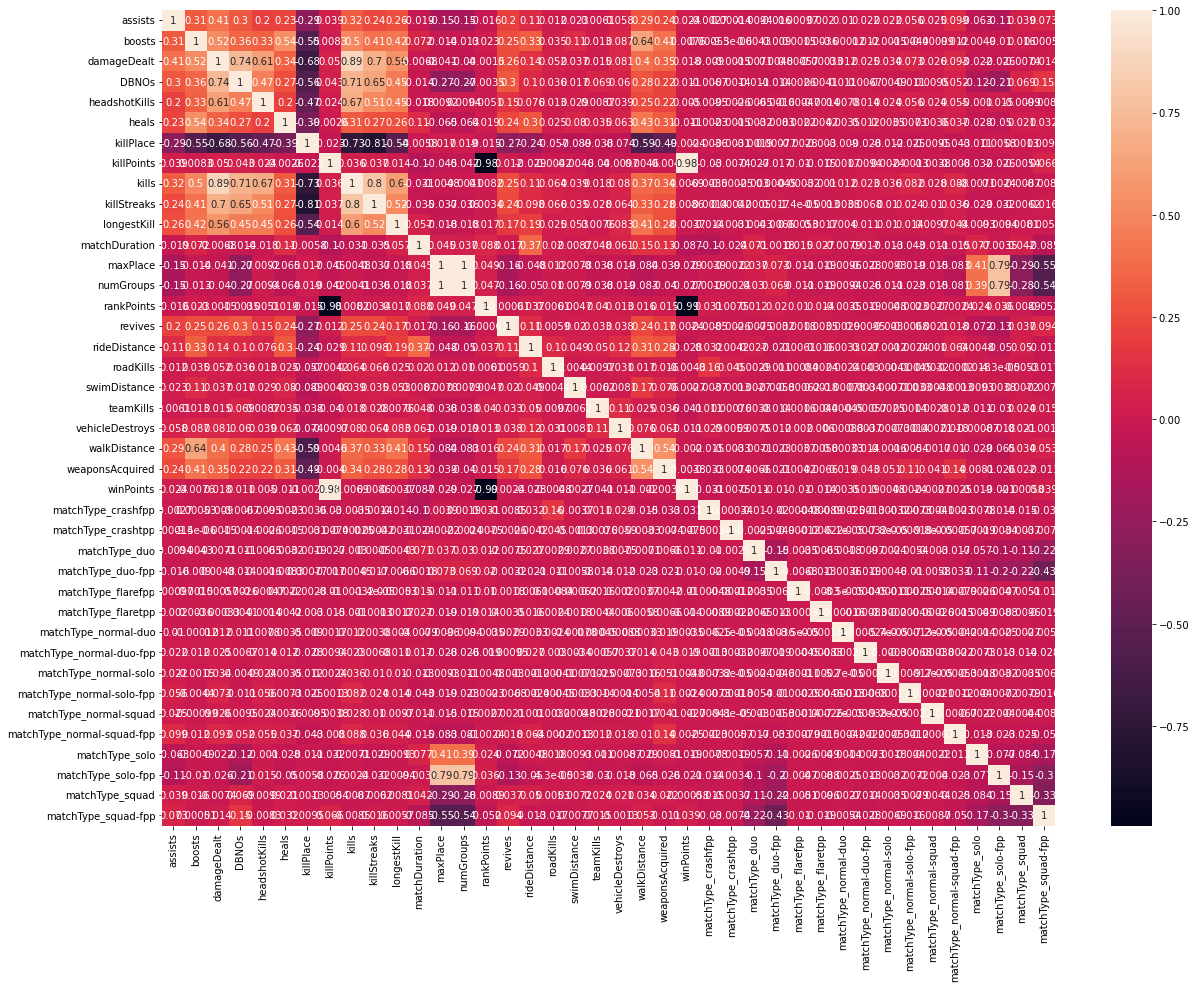

In [ ]:
# drop할 데이터들 추리기(결측치, 상관없는 컬럼, 다중공선성 컬럼)
#종속변수인 winPlacePerc가 Nan값인 row를 지워줍니다. #어케 하더라...
# train[train.isnull().any(axis=1)


plt.figure(figsize=(20,15))
sns.heatmap(X.corr(), annot=True)

이런 식으로 여러가지 그래프를 그려가며, 데이터에 대한 인사이트를 얻습니다!

### 3. 전처리

#### 결측치 처리

In [ ]:
# 결측치가 있는 column


In [ ]:
# 중복정보가 있는 column 제거하기 위해 상관계수를 확인해봅니다.
correlated_features = 

#### 다중공선성 처리

In [ ]:
# 상관계수가 threshold(e.g. 0.8)를 넘기는 feature들을 제거합니다.
threshold = 

#### Encoding Categorical Features

In [ ]:
# dtype이 object인 변수들 처리.


#### feature extraction

- 차원의 저주를 해결하거나, 데이터의 feature 조합을 이용하는 새로운 feature를 생성할 때, PCA를 사용합니다.

- 분석에 사용할 feature를 선택하는 과정도 포함합니다.

In [ ]:
# PCA 적용
from sklearn.decomposition import PCA

if feature_reducing:
    pca = PCA(n_components=0.9) # PCA(n_components=6)
    pca_data = pca.fit_transform(X)

### 4. 학습 데이터 분할

In [17]:
# 첫번째 테스트용으로 사용하고, 실제 학습시에는 K-Fold CV를 사용합니다.
# train : test = 8 : 2
from sklearn.model_selection import train_test_split

X = train1.drop(columns=["winPlacePerc"])
y = train1.winPlacePerc

# X2 = train2_OHE.drop(columns=["winPlacePerc"])
# y2 = train2_OHE.winPlacePerc

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X, y, testsize=0.2, random_state=42)

In [18]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
# print(X2_train.shape, y2_train.shape, X2_test.shape, y2_test.shape)

(3112875, 25) (3112875,) (1334090, 25) (1334090,)


### 5. 학습 및 평가

In [ ]:
# 간단하게 LightGBM 테스트
# 적당한 hyper-parameter 조합을 두었습니다. (항상 best는 아닙니다. 예시입니다.)

param_grid = {
    "max_bin" : 20,
    "learning_rate" : 0.0025,
    "objective" : "regression",
    "boosting_type" : "gbdt",
    "metric" : "mae",
    "sub_feature" : 0.345,
    "bagging_fraction" : 0.85,
    "bagging_freq" : 40,
    "num_leaves" : 512,
    "min_data" : 500,
    "min_hessian" : 0.05,
    "verbose" : 2,
    "feature_fraction_seed" : 2,
    "bagging_seed" : 3
}

model = LGBMRegressor(**param_grid)

In [ ]:
print("\nFitting LightGBM...")
model.fit(X_train, y_train)


Fitting LightGBM...


LGBMRegressor(bagging_fraction=0.85, bagging_freq=40, bagging_seed=3,
              feature_fraction_seed=2, learning_rate=0.0025, max_bin=20,
              metric='mae', min_data=500, min_hessian=0.05, num_leaves=512,
              objective='regression', sub_feature=0.345, verbose=2)

In [ ]:
# metric은 그때마다 맞게 바꿔줘야 합니다.
evaluation_metric = mean_squared_error
evaluation_metric2 = r2_score


In [ ]:
print("Prediction")
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

train_score = evaluation_metric(y_train, pred_train)
test_score = evaluation_metric(y_test, pred_test)

print("Train Score : %.4f" % train_score)
print("Test Score : %.4f" % test_score)

print("Prediction2")
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

train_score2 = evaluation_metric2(y_train, pred_train)
test_score2 = evaluation_metric2(y_test, pred_test)

print("Train Score : %.4f" % train_score2)
print("Test Score : %.4f" % test_score2)

Prediction
Train Score : 0.0682
Test Score : 0.0682
Prediction2
Train Score : 0.2781
Test Score : 0.2781


학습

In [19]:
# 1. 사용할 함수를 불러옵니다. 랜덤포레스트,xgb 주석처리하고 해보자
from sklearn.linear_model import LinearRegression
from lightgbm.sklearn import LGBMRegressor
from xgboost.sklearn import XGBRegressor
# from sklearn.ensemble import RandomForestRegressor

# 2. 사용할 함수의 객체를 생성합니다.
reg = LinearRegression()
reg2 = LGBMRegressor()
reg3 = XGBRegressor()

# reg4 = LGBMRegressor() # 2번째
# reg3 = XGBRegressor()
# reg4 = RandomForestRegressor()


# 3. 학습
reg.fit(X_train, y_train) ### Regression : supervised learning --> parameter update.
reg2.fit(X_train, y_train)
reg3.fit(X_train, y_train)


#points들 드랍한거
# reg3.fit(X2_train, y2_train) ### Regression : supervised learning --> parameter update.
# reg4.fit(X2_train, y2_train)
# reg3.fit(X_train, y_train)

[06:16:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [20]:
# 학습 결과를 확인 (평가 지표.)

## TO-DO : Random Forest에 대한 결과도 추가해서 출력해보세요!
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

pred = reg.predict(X_train) # y_hat
pred2 = reg2.predict(X_train)
pred3 = reg3.predict(X_train) # y_hat

# pred4 = reg4.predict(X2_train)
# pred3 = reg3.predict(X_train) 

# val_pred = reg.predict(X_val)
# val_pred2 = reg2.predict(X_val)
# val_pred3 = reg3.predict(X_val)

print("----- Training -----")
print("--- Linear Regression ---")
print("MSE : %.4f" % mean_squared_error(y_train, pred))
print("MAE : %.4f" % mean_absolute_error(y_train, pred))
print("R2 : %.4f" % r2_score(y_train, pred))

print("\n\n--- LightGBM ---")
print("MSE : %.4f" % mean_squared_error(y_train, pred2))
print("MAE : %.4f" % mean_absolute_error(y_train, pred2))
print("R2 : %.4f" % r2_score(y_train, pred2))

print("\n\n--- XGB ---")
print("MSE : %.4f" % mean_squared_error(y_train, pred3))
print("MAE : %.4f" % mean_absolute_error(y_train, pred3))
print("R2 : %.4f" % r2_score(y_train, pred3))

# print("\n\n--- LightGBM2 ---")
# print("MSE : %.4f" % mean_squared_error(y2_train, pred4))
# print("MAE : %.4f" % mean_absolute_error(y_train, pred4))
# print("R2 : %.4f" % r2_score(y2_train, pred4))

# print("\n\n--- XGBoost ---")
# print("MSE : %.4f" % mean_squared_error(y_train, pred3))
# print("R2 : %.4f" % r2_score(y_train, pred3))

# print("\n\n----- Validation -----")
# print("--- Linear Regression ---")
# print("MSE : %.4f" % mean_squared_error(y_val, val_pred))
# print("R2 : %.4f" % r2_score(y_val, val_pred))
# print("\n\n--- LightGBM ---")
# print("MSE : %.4f" % mean_squared_error(y_val, val_pred2))
# print("R2 : %.4f" % r2_score(y_val, val_pred2))
# print("\n\n--- RandomForest ---")
# print("MSE : %.4f" % mean_squared_error(y_val, val_pred3))
# print("R2 : %.4f" % r2_score(y_val, val_pred3))

----- Training -----
--- Linear Regression ---
MSE : 0.0160
MAE : 0.0922
R2 : 0.8311


--- LightGBM ---
MSE : 0.0069
MAE : 0.0596
R2 : 0.9270


--- XGB ---
MSE : 0.0094
MAE : 0.0689
R2 : 0.9001


In [21]:
result = reg.predict(X_test)
result2 = reg2.predict(X_test)
result3 = reg3.predict(X_test)
# result4 = reg4.predict(X2_test)

print("----- Test -----")
print("--- Linear Regression ---")
print("MSE : %.4f" % mean_squared_error(y_test, result))
print("MAE : %.4f" % mean_absolute_error(y_test, result))
print("R2 : %.4f" % r2_score(y_test, result))
print("\n\n--- LightGBM ---")
print("MSE : %.4f" % mean_squared_error(y_test, result2))
print("MAE : %.4f" % mean_absolute_error(y_test, result2))
print("R2 : %.4f" % r2_score(y_test, result2))
print("\n\n--- XGB ---")
print("MSE : %.4f" % mean_squared_error(y_test, result3))
print("MAE : %.4f" % mean_absolute_error(y_test, result3))
print("R2 : %.4f" % r2_score(y_test, result3))
# print("\n\n=---XGBoost ---")
# print("MSE : %.4f" %mean_squared_error(y_test, result3))
# print("R2 : %.4f"% r2_score(y_test, result3))

----- Test -----
--- Linear Regression ---
MSE : 0.0160
MAE : 0.0922
R2 : 0.8309


--- LightGBM ---
MSE : 0.0069
MAE : 0.0597
R2 : 0.9268


--- XGB ---
MSE : 0.0095
MAE : 0.0689
R2 : 0.8999


### 6. Hyper-parameter Tuning

> GridSearchCV

** LightGBM의 hyperparameter **

[Official Documentation] https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html 

[Blog 1] https://smecsm.tistory.com/133

[Blog 2] https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5

[Blog 3] https://nurilee.com/2020/04/03/lightgbm-definition-parameter-tuning/

In [ ]:
# GridSearchCV를 이용하여 가장 좋은 성능을 가지는 모델을 찾아봅시다. (이것은 첫번째엔 선택입니다.)
# Lightgbm은 hyper-parameter의 영향을 많이 받기 때문에, 저는 보통 맨처음에 한번 정도는 가볍게 GCV를 해봅니다.
# 성능 향상이 별로 없다면, lightgbm으로 돌린 대략적인 성능이 이 정도라고 생각하면 됩니다.
# 만약 성능 향상이 크다면, 지금 데이터는 hyper-parameter tuning을 빡빡하게 하면 성능 향상이 많이 이끌어 낼 수 있습니다.

from sklearn.model_selection import GridSearchCV

param_grid = {
    "max_depth" : [8, 16, None],
    "n_estimators" : [100, 300, 500],
    "max_bin" : [20],
    "learning_rate" : [0.001, 0.0025, 0.003],
    "objective" : ["regression"],
    "boosting_type" : ["gbdt"],
    "metric" : ["mae"],
    "sub_feature" : [0.345],
    "bagging_fraction" : [0.7, 0.75, 0.85],
    "bagging_freq" : [40],
    "num_leaves" : [256, 512],
    "min_data" : [500],
    "verbose" : [-1], # 필수
    "min_hessian" : [0.05],
    "feature_fraction_seed" : [2],
    "bagging_seed" : [3]
}


gcv = GridSearchCV(estimator=model, param_grid=param_grid, cv=5,
                  n_jobs=-1, verbose=1)

gcv.fit(X_train, y_train)
print("Best Estimator : ", gcv.best_estimator_)

In [ ]:
print("Prediction with Best Estimator")
gcv_pred_train = gcv.predict(X_train)
gcv_pred_test = gcv.predict(x_test)

gcv_train_score = evaluation_metric(y_train, gcv_pred_train)
gcv_test_score = evaluation_metric(y_test, gcv_pred_test)

print("Train MAE Score : %.4f" % gcv_train_score)
print("Test MAE Score : %.4f" % gcv_test_score)

In [ ]:
print("Performance Gain") # 이걸로 성능 향상 확인.
print("in train : ", (train_score - gcv_train_score))
print("in test : ", (test_score - gcv_test_score))

> optuna를 사용해봅시다 !

In [ ]:
def optimizer(trial, X, y, K):
    # 조절할 hyper-parameter 조합을 적어줍니다.
    n_estimators = 
    max_depth = 
    max_features = 
    
    
    # 원하는 모델을 지정합니다, optuna는 시간이 오래걸리기 때문에 저는 보통 RF로 일단 테스트를 해본 뒤에 LGBM을 사용합니다.
    model = RandomForestRegressor(n_estimators=n_estimators,
                                 max_depth=max_depth,
                                 max_features=max_features)
    
    
    # K-Fold Cross validation을 구현합니다.
    folds = KFold(n_splits=K)
    losses = []
    
    for train_idx, val_idx in folds.split(X, y):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]
        
        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]
        
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        loss = mean_absolute_error(y_val, preds)
        losses.append(loss)
    
    
    # K-Fold의 평균 loss값을 돌려줍니다.
    return np.mean(losses)

In [ ]:
K = # Kfold 수
opt_func = partial(optimizer, X=X_train, y=y_train, K)

study = optuna.create_study(direction="minimize") # 최소/최대 어느 방향의 최적값을 구할 건지.
study.optimize(opt_func, n_trials=5)

In [ ]:
# optuna가 시도했던 모든 실험 관련 데이터
study.trials_dataframe()

In [ ]:
print("Best Score: %.4f" % study.best_value) # best score 출력
print("Best params: ", study.best_trial.params) # best score일 때의 하이퍼파라미터들

In [ ]:
# 실험 기록 시각화
optuna.visualization.plot_optimization_history(study)

In [ ]:
# hyper-parameter들의 중요도
optuna.visualization.plot_param_importances(study)

### 7. 테스트 및 제출 파일 생성

In [ ]:
result = reg.predict(test1)
result2 = reg2.predict(test1) 
result3 = reg3.predict(test1)


In [ ]:
submission['winPlacePerc'] = result2
submission

,Id,winPlacePerc
0,9329eb41e215eb,0.262470
1,639bd0dcd7bda8,0.943501
2,63d5c8ef8dfe91,0.634434
3,cf5b81422591d1,0.548722
4,ee6a295187ba21,0.928396
...,...,...
1934169,a316c3a13887d5,0.741506
1934170,5312146b27d875,0.428993
1934171,fc8818b5b32ad3,0.884632
1934172,a0f91e35f8458f,0.835312


In [ ]:
submission.to_csv(base_path + "submission.csv", index=False)

In [ ]:
model = RandomForestRegressor(n_estimators=study.best_trial.params["n_estimators"],
                                 max_depth=study.best_trial.params["max_depth"],
                                 max_features=study.best_trial.params["max_features"])

model.fit(X_train, y_train)
preds = model.predict(X_test)
preds

In [ ]:
X_test # 원본 데이터랑 id가 맞는지 확인 해보기!

In [ ]:
submission = pd.DataFrame() # submission을 생성합니다.
submission

In [ ]:
submission.reset_index(drop=True).to_csv("submission.csv", index=False)